# Numba implementation of greedy search

Allow just-in-time compilation with numba.

In [38]:
RUN_BENCHMARKS = True

## Test data

As test data we generate simple binary random matrices $R \in \{0, 1\}^{m \times n}$ with a fixed proportion of 1-entries ($\alpha=0.5$) for a range of $n$ and $m$ values.

In [20]:
import numpy as np
import pandas as pd

RNG = np.random.default_rng(seed=0)

In [21]:
def rand_array(size, alpha=0.2):
    n, k = size
    d = np.arange(n*k)
    RNG.shuffle(d)
    d = (d < alpha*len(d)).astype(int)
    return d.reshape(n, k)

In [22]:
d_tiny = rand_array((10, 5), alpha=0.5)
d_tiny

array([[1, 1, 0, 1, 1],
       [1, 0, 1, 1, 0],
       [1, 1, 0, 1, 1],
       [0, 0, 0, 1, 1],
       [0, 1, 0, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 1, 1],
       [1, 0, 0, 1, 1],
       [0, 0, 0, 1, 0]])

In [23]:
ns = np.arange(5, 51, 5)
ms = np.arange(50, 501, 50)

alpha = 0.5

d = {}
for m in ms:
    for n in ns:
        X = rand_array((m, n), alpha=alpha)
        true_weights = RNG.random(n) * 10
        y = X @ true_weights + RNG.random(m)
        y = np.sign(y - y.mean())
        dfX = pd.DataFrame(data=X, index=None, columns=[f'x{i}' for i in range(X.shape[1])])
        dfy = pd.Series(data=y)
        d[(m, n)] = (dfX, dfy)

## Existing implementation

In [24]:
from realkd.rules import RuleBoostingEstimator, XGBRuleEstimator, logistic_loss

re = RuleBoostingEstimator(base_learner=XGBRuleEstimator(loss=logistic_loss, search='greedy'))

def re_fit(data):
  re.fit(data[0], data[1])

In [25]:
try:
    t_bm = t_bm if t_bm is not None else {}
except:
    t_bm = {}

if RUN_BENCHMARKS:
    t_bm = {}

    for i in ms:
        t_bm[(i, ns[0])] = %timeit -o re_fit(d[(i, ns[0])])

    for i in ns:
        t_bm[(ms[0], i)] = %timeit -o re_fit(d[(ms[0], i)])

In [26]:
import matplotlib.pyplot as plt

t_bm_mean = [t_bm[(i, ns[0])].average for i in ms]
t_bm_std = [t_bm[(i, ns[0])].stdev for i in ms]
plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(ms, t_bm_mean, marker='o')
plt.xlim(ms[0], ms[-1])
plt.xlabel('$m$')

plt.subplot(1, 2, 2)
t_bm_mean = [t_bm[(ms[0], j)].average for j in ns]
t_bm_std = [t_bm[(ms[0], j)].stdev for j in ns]
plt.plot(ns, t_bm_mean, marker='o')
plt.xlim(ns[0], ns[-1])
plt.xlabel('$n$')

plt.show()

KeyError: (50, 5)

# Numba just-in-time compilation - Building it up from 0

In [155]:
from numba import njit
import colorama

## Intersection

In [31]:
def baseNumpyIntersection(arr1, arr2):
    return np.intersect1d(arr1, arr2)


@njit()
def numbaNumpyIntersection(arr1, arr2):
    return np.intersect1d(arr1, arr2)

list1 = np.arange(100)
list2 = np.arange(50, 100)

# Run the function first before testing to compile it
numbaNumpyIntersection(list1, list2)
# print(numbaNumpyIntersection.inspect_types())
if RUN_BENCHMARKS:
    %timeit -o baseNumpyIntersection(list1, list2)
    %timeit -o numbaNumpyIntersection(list1, list2)

## Objective Function

In [91]:
from numpy import array, argsort, zeros_like
from math import inf

def build_numba_obj_function(X, y):
    loss = logistic_loss # TODO: Generalize
    reg = 1.0 # TODO: Generalize
    predictions = zeros_like(y) # TODO: Generalize
    g = array(loss.g(y, predictions))
    h = array(loss.h(y, predictions))
    r = g / h
    order = argsort(r)[::-1]
    g = g[order]
    h = h[order]
    n = y.shape[0]

    @njit
    def objective_function(ext):
        if len(ext) == 0:
            return -inf
        g_q = g[ext]
        h_q = h[ext]
        return g_q.sum() ** 2 / (2 * n * (reg + h_q.sum()))

    return objective_function

def get_ghreg(X, y):
    loss = logistic_loss # TODO: Generalize
    reg = 1.0 # TODO: Generalize
    predictions = zeros_like(y) # TODO: Generalize
    g = array(loss.g(y, predictions))
    h = array(loss.h(y, predictions))
    r = g / h
    order = argsort(r)[::-1]
    g = g[order]
    h = h[order]
    n = y.shape[0]

    return (g, h, reg)

@njit
def objective_function(g, h, reg, ext):
    if len(ext) == 0:
        return -inf
    g_q = g[ext]
    h_q = h[ext]
    return g_q.sum() ** 2 / (2 * n * (reg + h_q.sum()))

test_data_1 = d[(ms[0],ns[0])]
test_data_2 = d[(ms[0],ns[1])]
test_extent = np.arange(5, 20)

g1, h1, reg1 = get_ghreg(test_data_1[0], test_data_1[1])
g2, h2, reg2 = get_ghreg(test_data_2[0], test_data_2[1])

obj_fn_1 = build_numba_obj_function(test_data_1[0], test_data_1[1])
obj_fn_2 = build_numba_obj_function(test_data_2[0], test_data_2[1])
# obj_fn_3 = objective_function
# obj_fn_4 = objective_function

# Run the function first before testing to compile it
# print(obj_fn_1(test_extent))
# print(objective_function(g1, h1, reg1,test_extent))
# obj_fn.inspect_types()

if RUN_BENCHMARKS:
    %timeit -o -n 1 obj_fn_1(test_extent)
    %timeit -o -n 1 obj_fn_2(test_extent)
    %timeit -o -n 1 objective_function(g1, h1, reg1, test_extent)
    %timeit -o -n 1 objective_function(g1, h1, reg1, test_extent)

The slowest run took 821462.88 times longer than the fastest. This could mean that an intermediate result is being cached.
70.4 ms ± 172 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
The slowest run took 380643.06 times longer than the fastest. This could mean that an intermediate result is being cached.
21.8 ms ± 53.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
The slowest run took 234788.76 times longer than the fastest. This could mean that an intermediate result is being cached.
23.5 ms ± 57.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
The slowest run took 7.29 times longer than the fastest. This could mean that an intermediate result is being cached.
1.46 µs ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## find_best_new_index

2 Improvements here from the naive approach:
1. Pass Extents as a numba List, not a reflected list. This means changes to extents are not required to be reflected back in the python excecution environment
2. Nest objective function inside (to generalize - this will later be something like the following, which can then be cached as it will always be the same f)
```
def create_run_for_f(f):
  def abc(other_args, func_args):
    ...
    f(func_args, extent)
    ...
  return abc
```

In [179]:
from realkd.search import Conjunction, Context, KeyValueProposition, Constraint
from numba.typed import List
import numba

# @njit(parallel=True)
@njit()
def find_best_new_index(current_intent, current_extent, extents, initial_value, f, n, g, h, reg):
    best_i, best_ext = None, current_extent
    value = initial_value
    for i in range(n):
        if i in current_intent:
            continue
        new_extent = numbaNumpyIntersection(current_extent, extents[i])
        new_value = f(g, h, reg, new_extent)
        if new_value > value:
            value = new_value
            best_ext = new_extent
            best_i = i
    return (best_i, best_ext, value)

test_data = d[(ms[0],ns[1])]
test_indent = np.array([])
test_extent = np.arange(5, 20)

g1, h1, reg1 = get_ghreg(test_data[0], test_data_1[1])

ctx = Context.from_df(test_data[0])
g, h, reg = get_ghreg(test_data[0], test_data[1])

initial_extent = np.array(ctx.extension([]))
n = ctx.n
# extents = np.array(ctx.extents)
extents = List(ctx.extents)
# extents = np.array([np.array([1, 2, 3]), np.array([3, 1])])
attributes = ctx.attributes


# askdf
initial_value = objective_function(g, h, reg, initial_extent)

# print(extents)
print(extents[0])
print(numba.typeof(extents))
print(numba.typeof(extents[0]))
print(numba.typeof(ctx.extents[0]))
# find_best_new_index(test_indent, initial_extent, extents, initial_value, objective_function, n, g, h, reg)


%timeit -o find_best_new_index(test_indent, initial_extent, extents, initial_value, objective_function, n, g, h, reg)
%timeit -o find_best_new_index(test_indent, initial_extent, ctx.extents, initial_value, objective_function, n, g, h, reg)
find_best_new_index.inspect_types()


[ 1  3  7  8  9 11 12 13 18 20 25 27 28 30 31 33 34 48 49]
ListType[array(int64, 1d, C)]
array(int64, 1d, C)
array(int64, 1d, C)
144 µs ± 38.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
394 µs ± 81.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
find_best_new_index (array(float64, 1d, C), array(int64, 1d, C), ListType[array(int64, 1d, C)], float64, type(CPUDispatcher(<function objective_function at 0x7f26dc753ee0>)), int64, array(float64, 1d, C), array(float64, 1d, C), float64)
--------------------------------------------------------------------------------
# File: /tmp/ipykernel_1815/4279207250.py
# --- LINE 6 --- 

@njit()

# --- LINE 7 --- 

def find_best_new_index(current_intent, current_extent, extents, initial_value, f, n, g, h, reg):

    # --- LINE 8 --- 
    # label 0
    #   current_intent = arg(0, name=current_intent)  :: array(float64, 1d, C)
    #   current_extent = arg(1, name=current_extent)  :: array(int64, 1d, C)
    #   extents = arg(2, name=extents

## Demonstration of nested functions being faster

In [153]:
@njit
def f(a, b):
  x = 0
  for i in range(a**3):
    x = x + i**2
  return a + b**2

@njit
def fancy_fibonacci(f, stop):
  x1 = 1
  x2 = 2
  while x2 < stop:
    temp = x2
    x2 = f(x1, x2)
    x1 = temp

  return x1, x2

@njit
def fancy_fibonacci_inline(stop):
  def f_inline(a, b):
    x = 0
    for i in range(a**3):
      x = x + i**2
    return a + b**2

  x1 = 1
  x2 = 2
  while x2 < stop:
    temp = x2
    x2 = f_inline(x1, x2)
    x1 = temp

  return x1, x2

# fancy_fibonacci(f, 12000000)

# fancy_fibonacci.inspect_types()
# f.inspect_types()
%timeit -o fancy_fibonacci(f, 12000000)
%timeit -o fancy_fibonacci_inline(12000000)

The slowest run took 8.18 times longer than the fastest. This could mean that an intermediate result is being cached.
16.6 µs ± 19.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
176 ns ± 1.35 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


<TimeitResult : 176 ns ± 1.35 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)>

## Numba just-in-time compilation - putting it all together

In [177]:
from realkd.rules import RuleBoostingEstimator, XGBRuleEstimator, logistic_loss
from realkd.search import search_methods
from numba import njit
import pandas as pd
import sortednp as snp
import doctest

from collections import defaultdict, deque
from sortedcontainers import SortedSet
from math import inf
from heapq import heappop, heappush
from numpy import array
from bitarray import bitarray
import collections.abc

from math import inf
from numpy import arange, argsort, array, cumsum, exp, full_like, log2, stack, zeros, zeros_like
from pandas import qcut, Series
import time
from sklearn.base import BaseEstimator, clone

from realkd.search import Conjunction, Context, KeyValueProposition, Constraint
from bitarray.util import subset

from realkd.logic import Conjunction, Constraint, KeyValueProposition, TabulatedProposition

re = RuleBoostingEstimator(base_learner=XGBRuleEstimator(loss=logistic_loss, search='numba_greedy'))

def get_ghreg(X, y):
    loss = logistic_loss # TODO: Generalize
    reg = 1.0 # TODO: Generalize
    predictions = zeros_like(y) # TODO: Generalize
    g = array(loss.g(y, predictions))
    h = array(loss.h(y, predictions))
    r = g / h
    order = argsort(r)[::-1]
    g = g[order]
    h = h[order]
    n = y.shape[0]

    return (g, h, reg)

@njit
def objective_function(g, h, reg, ext):
    if len(ext) == 0:
        return -inf
    g_q = g[ext]
    h_q = h[ext]
    return g_q.sum() ** 2 / (2 * n * (reg + h_q.sum()))

@njit
def my_intersect(arr1, arr2):
    return np.array(set(arr1).intersection(arr2))

# https://stackoverflow.com/questions/59959207/intersection-of-two-lists-in-numba
@njit()
def JitListComp(l1, l2):
    l3 = np.array([i for i in l1 for j in l2 if i == j])
    return np.unique(l3)

@njit()
def numpy(l1, l2):
    return np.intersect1d(l1, l2)

# TODO: Clean up code inc. removing argument passing
@njit
def find_best_new_index(current_intent, current_extent, extents, initial_value, n, g, h, reg):
    def inline_objective_function(g, h, reg, ext):
        if len(ext) == 0:
            return -inf
        g_q = g[ext]
        h_q = h[ext]
        return g_q.sum() ** 2 / (2 * n * (reg + h_q.sum()))

    best_i, best_ext = None, current_extent
    value = initial_value
    for i in range(n):
        if i in current_intent:
            continue
        new_extent = numpy(current_extent, extents[i])
        new_value = inline_objective_function(g, h, reg, new_extent)
        if new_value > value:
            value = new_value
            best_ext = new_extent
            best_i = i
    return (best_i, best_ext, value)

# @njit
def numba_run(extent, n, extents, g, h, reg):
    """
    Runs the configured search.

    :return: :class:`~realkd.logic.Conjunction` that (approximately) maximizes objective
    """
    # print(g, h, reg)
    def inline_objective_function(g, h, reg, ext):
        if len(ext) == 0:
            return -inf
        g_q = g[ext]
        h_q = h[ext]
        return g_q.sum() ** 2 / (2 * n * (reg + h_q.sum()))

    t1 = time.perf_counter()
    intent = [-1]
    value = inline_objective_function(g, h, reg, extent)
    t2 = time.perf_counter()
    while True:
        best_i, best_ext, new_value = find_best_new_index(intent, extent, extents, value, n, g, h, reg)
        if best_i is not None:
            # Update intent and try again
            intent.append(best_i)
            extent = best_ext
            value = new_value
        else:
            # Intent can't get any better
            break
    t3 = time.perf_counter()
    print(t2-t1, t3-t2)
    return intent[1:]

class NumbaGreedySearch:
    def __init__(self, ctx, obj, bdn, g, h, reg, verbose=False, **kwargs):
        """

        :param Context ctx: the context defining the search space
        :param callable obj: objective function
        :param callable bnd: bounding function satisfying that ``bnd(q) >= max{obj(r) for r in successors(q)}`` (for signature compatibility only, not currently used)
        :param int verbose: level of verbosity

        """
        self.ctx = ctx
        self.f = obj
        self.verbose = verbose
        self.g = g
        self.h = h
        self.reg = reg

    def run(self):
        """
        Runs the configured search.

        :return: :class:`~realkd.logic.Conjunction` that (approximately) maximizes objective
        """
        # The context is essentially the "current" intent and extent
        # Also note intent implies extent
        # Initially all row indexes from existing extent are selected (i.e intent = [])
        t1 = time.perf_counter()
        initial_extent = np.array(self.ctx.extension([]))
        n = self.ctx.n
        extents = List(self.ctx.extents)
        attributes = self.ctx.attributes
        # print(self.g, self.h, self.reg)
        # Intent is a list of COLUMN indexes to select by
        t2 = time.perf_counter()
        intent = numba_run(initial_extent, n, extents, g=self.g, h=self.h, reg=self.reg)
        t3 = time.perf_counter()
        ll = Conjunction(map(lambda i: attributes[i], intent))
        t4 = time.perf_counter()
        # print(t2-t1, t3-t2, t4-t3)
        return ll


In [165]:
from realkd.search import GreedySearch

def build_numba_obj_function(X, y):
    loss = logistic_loss # TODO: Generalize
    reg = 1.0 # TODO: Generalize
    predictions = zeros_like(y) # TODO: Generalize
    g = array(loss.g(y, predictions))
    h = array(loss.h(y, predictions))
    r = g / h
    order = argsort(r)[::-1]
    g = g[order]
    h = h[order]
    n = y.shape[0]

    def objective_function(ext):
        if len(ext) == 0:
            return -inf
        g_q = g[ext]
        h_q = h[ext]
        return g_q.sum() ** 2 / (2 * n * (reg + h_q.sum()))

    return objective_function

def run_search_numba(data, context):
    ctx, g, h, reg, obj_fn = context
    search = NumbaGreedySearch(ctx=ctx, obj=objective_function, bdn=None, g=g, h=h, reg=reg)
    search.run()

pre_made_obj_fns = {}

def run_search_base(data, context):
    ctx, g, h, reg, obj_fn = context
    search = GreedySearch(ctx=ctx, obj=obj_fn, bdn=None)
    search.run()

In [178]:
data = d[(ms[0], ns[0])]
ctx = Context.from_df(data[0])
g, h, reg = get_ghreg(data[0], data[1])
obj_fn = build_numba_obj_function(data[0], data[1])
context = ctx, g, h, reg, obj_fn
run_search_numba(data, context)

4.5900000259280205e-05 1.7005551000002015


In [170]:
import warnings
warnings.filterwarnings("ignore")

t_numba = {}
t_base = {}

ms_to_plot = ms[:3]
ns_to_plot = ns[:3]

pre_made_ctx = {}

for m in ms_to_plot:
    data = d[(m, ns[0])]
    ctx = Context.from_df(data[0])
    g, h, reg = get_ghreg(data[0], data[1])
    obj_fn = build_numba_obj_function(data[0], data[1])
    pre_made_ctx[(m, ns[0])] = ctx, g, h, reg, obj_fn

for n in ns_to_plot:
    data = d[(ms[0], n)]
    ctx = Context.from_df(data[0])
    g, h, reg = get_ghreg(data[0], data[1])
    obj_fn = build_numba_obj_function(data[0], data[1])
    pre_made_ctx[(ms[0], n)] = ctx, g, h, reg, obj_fn


# Dry runs
run_search_numba(d[(ms[0], ns[0])], pre_made_ctx[(ms[0], ns[0])])
run_search_base(d[(ms[0], ns[0])], pre_made_ctx[(ms[0], ns[0])])

for m in ms_to_plot:
    t_numba[(m, ns[0])] = %timeit -o run_search_numba(d[(m, ns[0])], pre_made_ctx[(m, ns[0])])
    t_base[(m, ns[0])] = %timeit -o run_search_base(d[(m, ns[0])], pre_made_ctx[(m, ns[0])])

for n in ns_to_plot:
    t_numba[(ms[0], n)] = %timeit -o run_search_numba(d[(ms[0], n)], pre_made_ctx[(ms[0], n)])
    t_base[(ms[0], n)] = %timeit -o run_search_base(d[(ms[0], n)], pre_made_ctx[(ms[0], n)])

209 µs ± 4.99 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
154 µs ± 5.62 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
302 µs ± 9.65 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
183 µs ± 8.18 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
483 µs ± 16.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
235 µs ± 5.37 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
245 µs ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
166 µs ± 3.33 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
602 µs ± 22.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
520 µs ± 34.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
745 µs ± 11.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
652 µs ± 14.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


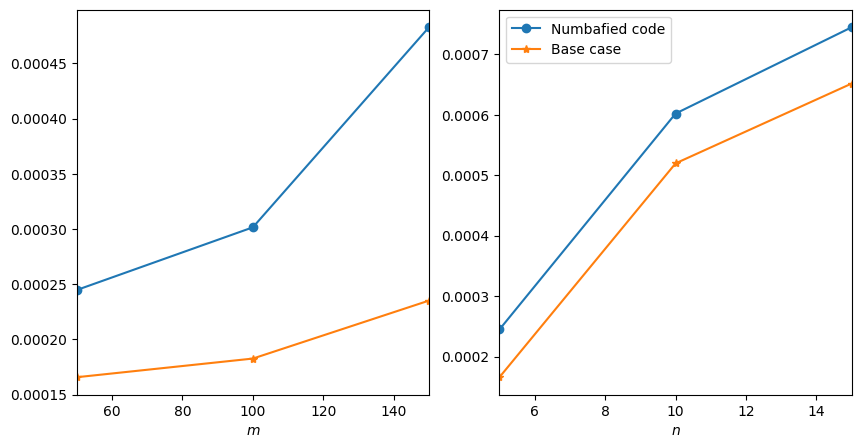

In [171]:
plt.subplots(1, 2, figsize=(10, 5))

t_numba_mean = [t_numba[(m, ns[0])].average for m in ms_to_plot]
t_numba_std = [t_numba[(m, ns[0])].stdev for m in ms_to_plot]
t_base_mean = [t_base[(m, ns[0])].average for m in ms_to_plot]
t_base_std = [t_base[(m, ns[0])].stdev for m in ms_to_plot]

plt.subplot(1, 2, 1)
plt.plot(ms_to_plot, t_numba_mean, marker='o')
plt.plot(ms_to_plot, t_base_mean, marker='*')
plt.xlim(ms_to_plot[0], ms_to_plot[-1])
plt.xlabel('$m$')

t_numba_mean = [t_numba[(ms[0], n)].average for n in ns_to_plot]
t_numba_std = [t_numba[(ms[0], n)].stdev for n in ns_to_plot]
t_base_mean = [t_base[(ms[0], n)].average for n in ns_to_plot]
t_base_std = [t_base[(ms[0], n)].stdev for n in ns_to_plot]

plt.subplot(1, 2, 2)
plt.plot(ns_to_plot, t_numba_mean, marker='o', label='Numbafied code')
plt.plot(ns_to_plot, t_base_mean, marker='*', label='Base case')
plt.xlim(ns_to_plot[0], ns_to_plot[-1])
plt.xlabel('$n$')
plt.legend()

plt.show()